In [78]:
import pandas as pd 
import numpy as np
import joblib
import os
import sklearn
import xgboost
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold


In [79]:
print("Python:", os.sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("joblib:", joblib.__version__)

Python: 3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 13:52:56) [MSC v.1942 64 bit (AMD64)]
pandas: 2.2.3
numpy: 2.2.5
scikit-learn: 1.6.1
xgboost: 3.0.1
joblib: 1.5.1


## Environment dan Versi Library

Notebook ini dijalankan menggunakan **Python 3.13.2 (Anaconda)** dengan versi library sebagai berikut:

| Library       | Version  |
|---------------|----------|
| pandas        | 2.2.3    |
| numpy         | 2.2.5    |
| scikit-learn  | 1.6.1    |
| xgboost       | 3.0.1    |
| joblib        | 1.5.1    |

Untuk mereplikasi environment ini, jalankan:
```bash
pip install -r requirements.txt


In [80]:
df=pd.read_csv('dataset/recruitment_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB


## Convert data int to category 

In [81]:
# cols_to_convert = ["Gender", "EducationLevel", "RecruitmentStrategy"]

# # ubah tipe data ke category
# df[cols_to_convert] = df[cols_to_convert].astype("category")

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB


##  Split Data 

In [83]:
X = df.drop("HiringDecision", axis=1)  
y = df["HiringDecision"]

# split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Ukuran X_train:", X_train.shape)
print("Ukuran X_test :", X_test.shape)
print("Ukuran y_train:", y_train.shape)
print("Ukuran y_test :", y_test.shape)

# gabungkan kembali X dan y agar sesuai dengan data awal
train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

# simpan ke CSV
train_set.to_csv("dataset/train.csv", index=False)
test_set.to_csv("dataset/test.csv", index=False)

print("Dataset berhasil disimpan ke 'train.csv' dan 'test.csv'")

Ukuran X_train: (1200, 10)
Ukuran X_test : (300, 10)
Ukuran y_train: (1200,)
Ukuran y_test : (300,)
Dataset berhasil disimpan ke 'train.csv' dan 'test.csv'


## Pipeline Data Preprocessing

In [84]:
# =====================
# 1. Load data from CSV
# =====================
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

X_train = train_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_train = train_df["HiringDecision"]

X_test = test_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_test = test_df["HiringDecision"]



In [85]:

# =====================
# 3. Preprocessing setup
# =====================

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # 1. Drop duplicates
        X = X.drop_duplicates()
        
        # 2. Missing value handling
        for col in X.select_dtypes(include=["float", "int"]).columns:
            X[col] = X[col].fillna(X[col].median())   # numeric → median
        for col in X.select_dtypes(include=["object"]).columns:
            X[col] = X[col].fillna(X[col].mode()[0]) # categorical → modus
        
        # 3. Outlier handling (IQR method pada numerical)
        for col in X.select_dtypes(include=["float", "int"]).columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
            X[col] = np.where(X[col] < lower, lower,
                              np.where(X[col] > upper, upper, X[col]))
        
        return X
    
# b. ExperienceYears → binning (junior/mid/senior)
def bin_experience(x):
    bins = np.array(x).astype(int).ravel()
    labels = []
    for v in bins:
        if v <=2:
            labels.append("Junior")
        elif v <=5:
            labels.append("Mid")
        else:
            labels.append("Senior")
    return np.array(labels).reshape(-1,1)


# a. EducationLevel → OH encode
edu_pipeline = Pipeline([
    ("onehot", OneHotEncoder(drop=None))  # one-hot encode EducationLevel
])

exp_pipeline = Pipeline([
    ("binning", FunctionTransformer(bin_experience, validate=False,feature_names_out="one-to-one")),
    ("onehot", OneHotEncoder(drop=None))  # one-hot encode hasil binning
])

# c. RecruitmentStrategy → one-hot encode
recruitment_pipeline = Pipeline([
    ("onehot", OneHotEncoder(drop=None))
])

# d. Numerical features → scaling
num_features = ["InterviewScore", "SkillScore", "PersonalityScore"]
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# =====================
# 4. ColumnTransformer
# =====================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_features),
        ("recruitment", recruitment_pipeline, ["RecruitmentStrategy"]),
        ("education", edu_pipeline, ["EducationLevel"]),        
        ("experience", exp_pipeline, ["ExperienceYears"]),
    ],
    remainder="drop"
)


# Pipeline gabungan: cleaning + preprocessing


preprocessor.fit(X_train)
# # Simpan pipeline preprocessing
joblib.dump(preprocessor, "preprocesor_none.pkl")
print("Pipeline preprocessing berhasil disimpan.")



full_pipeline = Pipeline([
    ("cleaning", DataCleaner()),   # tahap cleaning
    ("preprocessing", preprocessor) # tahap preprocessing (OH, scaling, dsb.)
])
# Transform data
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed  = full_pipeline.transform(X_test)

print("Train shape:", X_train_transformed.shape)
print("Test shape :", X_test_transformed.shape)





Pipeline preprocessing berhasil disimpan.
Train shape: (1200, 13)
Test shape : (300, 13)


## Modeling

## Test to many models

In [86]:
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

def evaluate_models(models, X_train, y_train, X_test, y_test, save_csv=True):
    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)

        # === TRAIN ===
        y_train_pred = model.predict(X_train)
        y_train_prob = model.predict_proba(X_train)[:, 1]
        report_train = classification_report(y_train, y_train_pred, output_dict=True)
        roc_auc_train = roc_auc_score(y_train, y_train_prob)

        # === TEST ===
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1]
        report_test = classification_report(y_test, y_test_pred, output_dict=True)
        roc_auc_test = roc_auc_score(y_test, y_test_prob)

        # === Gabungkan semua metrik ===
        metrics = {
            "Model":               [name, name],  # supaya ada di Train & Test
            "Precision ": [round(report_train["1"]["precision"], 3), round(report_test["1"]["precision"], 3)],
            # "Recall (class 1)":    [round(report_train["1"]["recall"], 3),    round(report_test["1"]["recall"], 3)],
            "F1-score ":  [round(report_train["1"]["f1-score"], 3),  round(report_test["1"]["f1-score"], 3)],
            # "Accuracy":            [round(report_train["accuracy"], 3),       round(report_test["accuracy"], 3)],
            "ROC AUC":             [round(roc_auc_train, 3),                  round(roc_auc_test, 3)]
        }

        df_metrics = pd.DataFrame(metrics, index=["Train", "Test"])

        # === Hitung Gap (%) hanya untuk kolom numerik ===
        numeric_cols = df_metrics.select_dtypes(include="number").columns
        gap_values = ((df_metrics.loc["Train", numeric_cols] - df_metrics.loc["Test", numeric_cols])
                      / df_metrics.loc["Train", numeric_cols] * 100).round(2)

        # tambahkan model di gap row
        gap_row = pd.Series({col: gap_values.get(col, None) for col in df_metrics.columns} | {"Model": name},name="Gap (%)")

        # gap_row = pd.Series({col: gap_values.get(col, None) for col in df_metrics.columns}, name="Gap (%)")
        gap_row["Model"] = name

        # gabungkan
        df_metrics = pd.concat([df_metrics, gap_row.to_frame().T])

        # Reset index agar ada kolom Dataset
        df_metrics = df_metrics.reset_index().rename(columns={"index": "Dataset"})

          # Hanya ambil baris Test & Gap
        df_metrics = df_metrics[df_metrics["Dataset"].isin(["Test", "Gap (%)"])]

        # Urutkan kolom: Model dulu
        cols = ["Model", "Dataset"] + [c for c in df_metrics.columns if c not in ["Model", "Dataset"]]
        df_metrics = df_metrics[cols]

        results.append(df_metrics)

    # Gabungkan semua hasil
    final_results = pd.concat(results, ignore_index=True)

    # === Ranking berdasarkan ROC AUC Test ===
    ranking = (
        final_results[final_results["Dataset"] == "Test"]
        .sort_values(by="ROC AUC", ascending=False)[["Model", "ROC AUC"]]
        .reset_index(drop=True)
    )
    ranking.index = ranking.index + 1  # biar mulai dari 1

    return final_results, ranking


    # # Simpan ke CSV kalau diminta
    # if save_csv:
    #     final_results.to_csv("evaluation_results.csv", index=False)
    #     ranking.to_csv("model_ranking.csv", index=False)
    #     print("✅ Hasil evaluasi semua model disimpan ke evaluation_results.csv")
    #     print("✅ Ranking model (berdasarkan ROC AUC Test) disimpan ke model_ranking.csv")

    # return final_results, ranking





In [87]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced"),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=42
    )
}

# ==== Panggil fungsi ====
final_results, ranking = evaluate_models(models, X_train_transformed, y_train, X_test_transformed, y_test)

print("\n📊 Hasil Evaluasi Model:")
display(final_results)

print("\n🏆 Ranking Model berdasarkan ROC AUC (Test):")
display(ranking)


📊 Hasil Evaluasi Model:


,Model,Dataset,Precision,F1-score,ROC AUC
0,Logistic Regression,Test,0.755,0.804,0.922
1,Logistic Regression,Gap (%),1.048493,2.070646,0.539374
2,KNN,Test,0.92,0.821,0.914
3,KNN,Gap (%),1.181525,8.777778,6.448311
4,Decision Tree,Test,0.816,0.789,0.843
5,Decision Tree,Gap (%),18.4,21.1,15.7
6,Random Forest,Test,0.938,0.867,0.933
7,Random Forest,Gap (%),6.2,13.213213,6.7
8,Gradient Boosting,Test,0.962,0.884,0.935
9,Gradient Boosting,Gap (%),1.028807,6.455026,3.608247



🏆 Ranking Model berdasarkan ROC AUC (Test):


,Model,ROC AUC
1,Gradient Boosting,0.935
2,Random Forest,0.933
3,SVM,0.93
4,XGBoost,0.924
5,Logistic Regression,0.922
6,KNN,0.914
7,Naive Bayes,0.87
8,Decision Tree,0.843


# Hyperparameter Tuning untuk random forest dan gradient boosting

## Random forest , Gradient Boosting & XGBoost

In [88]:
# =========================================
# Fungsi Evaluasi Model (Train vs Test)
# =========================================
def evaluate_train_test(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Prediksi Train
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]

    # Prediksi Test
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Hasil Train
    train_results = {
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred),
        "Recall": recall_score(y_train, y_train_pred),
        "F1-Score": f1_score(y_train, y_train_pred),
        "ROC-AUC": roc_auc_score(y_train, y_train_prob)
    }

    # Hasil Test
    test_results = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_prob)
    }

    # Gap (%)
    gap_results = {m: 100 * (train_results[m] - test_results[m]) for m in train_results}

    # Buat DataFrame untuk tampilan tabel
    df_results = pd.DataFrame([
        {"Model": model_name, "Dataset": "Train", **train_results},
        {"Model": model_name, "Dataset": "Test", **test_results},
        {"Model": model_name, "Dataset": "Gap (%)", **gap_results},
    ])

    return df_results

In [89]:

# =========================================
# Random Forest dengan RandomizedSearchCV
# =========================================
rf = RandomForestClassifier(random_state=42)

rf_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# ✅ gunakan X_train_transformed dan X_test_transformed
rf_random.fit(X_train_transformed, y_train)

print("="*40)
print("===== Hasil Hyperparameter Tuning (Random Forest) =====")
print("Best Hyperparameter:", rf_random.best_params_)
print("Best F1 Score :", rf_random.best_score_)

# Evaluasi Train vs Test
best_rf = rf_random.best_estimator_
df_rf_eval = evaluate_train_test(best_rf, X_train_transformed, y_train,
                                 X_test_transformed, y_test,
                                 model_name="Random Forest")
print("\nResult Model evaluation Train vs Test:\n")
display(df_rf_eval)

# =========================================
# 2. Gradient Boosting
# =========================================
gb = GradientBoostingClassifier(random_state=42)
gb_param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

gb_random = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
gb_random.fit(X_train_transformed, y_train)

print("="*40)
print("===== Hasil Hyperparameter Tuning (Gradient Boosting) =====")
print("Best Hyperparameter:", gb_random.best_params_)
print("Best F1 Score :", gb_random.best_score_)

best_gb = gb_random.best_estimator_
df_gb_eval = evaluate_train_test(best_gb, X_train_transformed, y_train,
                                 X_test_transformed, y_test,
                                 model_name="Gradient Boosting")
display(df_gb_eval)

# =========================================
# 3. XGBoost
# =========================================
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [2, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=30,
    cv=cv,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
xgb_random.fit(X_train_transformed, y_train)

print("="*40)
print("===== Hasil Hyperparameter Tuning (XGBoost) =====")
print("Best Hyperparameter:", xgb_random.best_params_)
print("Best F1 Score :", xgb_random.best_score_)

best_xgb = xgb_random.best_estimator_
df_xgb_eval = evaluate_train_test(best_xgb, X_train_transformed, y_train,
                                  X_test_transformed, y_test,
                                  model_name="XGBoost")
display(df_xgb_eval)


# =========================================
# Gabungkan semua hasil evaluasi jadi 1 tabel
# =========================================
final_results = pd.concat([df_rf_eval, df_gb_eval, df_xgb_eval], ignore_index=True)
print("\n================ Final Comparison ================")
display(final_results)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
===== Hasil Hyperparameter Tuning (Random Forest) =====
Best Hyperparameter: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Best F1 Score : 0.8825159280692481

Result Model evaluation Train vs Test:



,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,Train,0.963333,0.971264,0.908602,0.938889,0.997305
1,Random Forest,Test,0.930000,0.950000,0.817204,0.878613,0.935068
2,Random Forest,Gap (%),3.333333,2.126437,9.139785,6.027617,6.223703


Fitting 5 folds for each of 30 candidates, totalling 150 fits
===== Hasil Hyperparameter Tuning (Gradient Boosting) =====
Best Hyperparameter: {'subsample': 1.0, 'n_estimators': np.int64(450), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 7, 'learning_rate': np.float64(0.10666666666666666)}
Best F1 Score : 0.8948170026669293


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Gradient Boosting,Train,1.000000,1.0000,1.000000,1.000000,1.000000
1,Gradient Boosting,Test,0.923333,0.9375,0.806452,0.867052,0.927069
2,Gradient Boosting,Gap (%),7.666667,6.2500,19.354839,13.294798,7.293128


Fitting 5 folds for each of 30 candidates, totalling 150 fits
===== Hasil Hyperparameter Tuning (XGBoost) =====
Best Hyperparameter: {'subsample': 1.0, 'n_estimators': np.int64(100), 'max_depth': 7, 'learning_rate': np.float64(0.20333333333333334), 'gamma': 1, 'colsample_bytree': 0.8}
Best F1 Score : 0.8896382706079461


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,XGBoost,Train,0.966667,0.974286,0.916667,0.944598,0.991911
1,XGBoost,Test,0.920000,0.948052,0.784946,0.858824,0.928835
2,XGBoost,Gap (%),4.666667,2.623377,13.172043,8.577481,6.307627



================ Final Comparison ================


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,Train,0.963333,0.971264,0.908602,0.938889,0.997305
1,Random Forest,Test,0.930000,0.950000,0.817204,0.878613,0.935068
2,Random Forest,Gap (%),3.333333,2.126437,9.139785,6.027617,6.223703
3,Gradient Boosting,Train,1.000000,1.000000,1.000000,1.000000,1.000000
4,Gradient Boosting,Test,0.923333,0.937500,0.806452,0.867052,0.927069
5,Gradient Boosting,Gap (%),7.666667,6.250000,19.354839,13.294798,7.293128
6,XGBoost,Train,0.966667,0.974286,0.916667,0.944598,0.991911
7,XGBoost,Test,0.920000,0.948052,0.784946,0.858824,0.928835
8,XGBoost,Gap (%),4.666667,2.623377,13.172043,8.577481,6.307627


## XGBoost memberikan hasil yang lebih baik dan stabil

In [90]:
# =========================================
# 3. XGBoost
# =========================================
xgb = XGBClassifier(random_state=42, eval_metric='logloss')


xgb_param_dist = {
    'n_estimators': np.arange(100, 501, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [2, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=30,
    cv=cv,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
xgb_random.fit(X_train_transformed, y_train)

print("="*40)
print("===== Hasil Hyperparameter Tuning  RandomizedSearchCV (XGBoost) =====")
print("Best Hyperparameter:", xgb_random.best_params_)
print("Best F1 Score :", xgb_random.best_score_)

best_xgb = xgb_random.best_estimator_
df_xgb_eval = evaluate_train_test(best_xgb, X_train_transformed, y_train,
                                  X_test_transformed, y_test,
                                  model_name="XGBoost")
display(df_xgb_eval)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
===== Hasil Hyperparameter Tuning  RandomizedSearchCV (XGBoost) =====
Best Hyperparameter: {'subsample': 1.0, 'n_estimators': np.int64(100), 'max_depth': 7, 'learning_rate': np.float64(0.20333333333333334), 'gamma': 1, 'colsample_bytree': 0.8}
Best F1 Score : 0.8896382706079461


,Model,Dataset,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,XGBoost,Train,0.966667,0.974286,0.916667,0.944598,0.991911
1,XGBoost,Test,0.920000,0.948052,0.784946,0.858824,0.928835
2,XGBoost,Gap (%),4.666667,2.623377,13.172043,8.577481,6.307627


In [91]:
model_filename = 'best_xgboost_model_none.pkl'
joblib.dump(best_xgb, model_filename)
print(f"\nModel terbaik berhasil disimpan di file '{model_filename}'")


Model terbaik berhasil disimpan di file 'best_xgboost_model_none.pkl'


In [92]:
joblib.dump(best_xgb, 'best_xgboost_model_none.joblib')
print(f"\nModel terbaik berhasil disimpan di file ")


Model terbaik berhasil disimpan di file 


In [93]:
try:
    best_xgboost_model = joblib.load('best_xgboost_model_none.pkl')
    print("Model berhasil dimuat.")
except FileNotFoundError:
    print("File 'best_xgboost_model.pkl' tidak ditemukan. Pastikan path sudah benar.")

Model berhasil dimuat.


In [94]:
y_pred = best_xgboost_model.predict(X_test_transformed)
print("Prediksi berhasil dilakukan.")

Prediksi berhasil dilakukan.


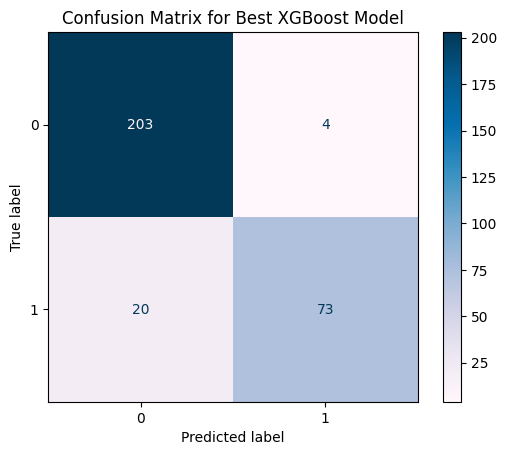

Confusion Matrix:
[[203   4]
 [ 20  73]]


In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Tampilkan visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgboost_model.classes_)
disp.plot(cmap='PuBu')

# Tambahkan judul dan tampilkan plot
plt.title('Confusion Matrix for Best XGBoost Model')
plt.show()

# Jika ingin melihat angkanya saja
print("Confusion Matrix:")
print(cm)

In [96]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced"),
    "XGBoost (Tuned)": best_xgb
}

# ==== Panggil fungsi ====
final_results_xgb_logreg, ranking = evaluate_models(models, X_train_transformed, y_train, X_test_transformed, y_test)

print("\n📊 Hasil Evaluasi Model:")
display(final_results_xgb_logreg)

print("\n🏆 Ranking Model berdasarkan ROC AUC (Test):")
display(ranking)
# # # Nama folder yang diinginkan
# folder_path = 'file_exp'

# # Cek apakah folder sudah ada, jika tidak, buat folder tersebut
# if not os.path.exists(folder_path):
#     os.path.makedirs(folder_path)
#     print(f"Folder '{folder_path}' berhasil dibuat.")

# # Buat path lengkap untuk file Excel
# file_path = os.path.join(folder_path, 'final_results_xgb_logreg.xlsx')

# # Asumsikan 'hasil_evaluasi' adalah DataFrame
# final_results_xgb_logreg.to_excel(file_path, index=True)

# print(f"Hasil evaluasi telah berhasil disimpan ke: {file_path}")


📊 Hasil Evaluasi Model:


,Model,Dataset,Precision,F1-score,ROC AUC
0,Logistic Regression,Test,0.755,0.804,0.922
1,Logistic Regression,Gap (%),1.048493,2.070646,0.539374
2,XGBoost (Tuned),Test,0.948,0.859,0.929
3,XGBoost (Tuned),Gap (%),2.669405,9.100529,6.350806



🏆 Ranking Model berdasarkan ROC AUC (Test):


,Model,ROC AUC
1,XGBoost (Tuned),0.929
2,Logistic Regression,0.922
